# Исследование продаж игр интернет магазина "Стримчик"
Я получил архив с информацией о продаже игр за несколько десятков лет. Данные содержат в себе информацию о названии игр, их жанре, платформе, количестве продаж по различным регионам, а также оценки и рейтинг возраста игр. Необходимо выявить закономерности успеха игр.

Моя цель: Проанализировать данные, выявить закономерности успеха игр и сделать выводы, которые помогут решению бизнес-задачи

Мои задачи:
    
    * обзор данных
    * предобработка данных
    * исследовательский анализ
    * составить портрет потенциального пользователя для каждого региона
    * сформулировать и проверить статистические гипотезы
    * формулировка выводов и рекомендаций

#### Импортирование библиотек

In [1]:
#Импортирование необходимых библиотек
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

#### Выгрузка данных

In [2]:
df = pd.read_csv('/datasets/games.csv') #Выгрузка данных

In [3]:
df.head() #Проверка на правильную выгрузку

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info() #Вывод информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В информации о данных видны пропуски, неверная типизация столбца Year_of_Release и User_Score и неудобные названия столбцов,так как встречаются символы в верхнем регистре

#### Предобработка данных

In [5]:
data = df.copy()

Создаём копию датафрейма для изменения и работы с данными

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Преобразование названий столбцов в нижний регистр

##### Работа с пропусками

In [7]:
data.isna().sum() #Вывод столбцов с пропущенными значениями

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
data = data.dropna(subset=['name'])
data['name'].isna().sum() #Проверка на удаление пропущенных значений

0

В данных присутствует всего пара пропущенных значений в столбце 'name'. Название игры является важным признаком данных,а информация в этих строках пропущенна на половину, в том числе и в столбце 'genre. Было принято решение их удалить.

In [10]:
data.loc[data['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [11]:
data = data.dropna(subset=['year_of_release'])
data['year_of_release'].isna().sum() #Проверка на удаление пропущенных значений

0

От даты зачастую зависят тренды, продажи, технологии и жанры игр. Также в дальнейшем я буду проводить исследовательский анализ связанный с датой на прямую, поэтому их замена медианой или средним значением сильно исказит данные. Пропущенных данных с датой не так много, поэтому пропуски были удалены для улучшения качества анализа

В столбцах critic_score и user_score пропуски встречаются примерно в половине всех данных. При удалении или замене пропусков в этих столбцах мы потеряем объём информации или точность нашего анализа. Было принято решение оставить пропуски, а отдельные исследования по этим столбцам проводить в отдельном датафрейме без пропусков в них

In [12]:
data['rating'] = data['rating'].fillna('unknown')
display(data['rating'].isna().sum()) #Проверка замены пропущенных значений
data['rating'].unique()

0

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Столбец с возрастным рейтингом имеет много пропуском, но он не является главным признаком данных. Поэтому я пришёл к замене пропусков константным значением

##### Преобразование типов данных

In [13]:
#Проверка на значение с плавающей точкой в столбце
data.loc[data['year_of_release'].notna() & data['year_of_release'] % 1 != 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Pandas определил тип данных из-за пропусков не правильно. Необходимо преобразовать тип данных в int

In [14]:
data['year_of_release'] = data['year_of_release'].astype('int')
data.dtypes['year_of_release']

dtype('int64')

In [15]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Были обнаруженны строковые значения в столбце. Приобразуем тип столбца в float, а строковые значения заменим на NaN

In [16]:
data['user_score'] = pd.to_numeric(data['user_score'],errors='coerce')
data.dtypes['user_score']

dtype('float64')

In [17]:
#Проверка всех предобработанных данных
display(data.head())
data.isna().sum()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown


name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

##### Поиск дубликатов

###### Поиск явных дубликатов

In [18]:
data.duplicated().sum() #Поиск явных дубликатов

0

###### Поиск неявных дубликатов

In [19]:
#Копируем датафрейм для преобразования всех номинативных переменных в нижний регистр и проверки на дубликаты
data_lower =  data.copy()

In [20]:
#Убираем у названий лишние пробелы по краям и преобразуем символы в нижний регистр
data_lower['name'] = data_lower['name'].str.lower().str.strip() 
data_lower['genre'] = data_lower['genre'].str.lower().str.strip()
data_lower['platform'] = data_lower['platform'].str.lower().str.strip()
#Проверяем на наличие неявных дубликатов в уникальных значениях 
print('Уникальные значения столбца "genre":',data_lower['genre'].unique())
print('Уникальные значения столбца "platform":',data_lower['platform'].unique())

Уникальные значения столбца "genre": ['sports' 'platform' 'racing' 'role-playing' 'puzzle' 'misc' 'shooter'
 'simulation' 'action' 'fighting' 'adventure' 'strategy']
Уникальные значения столбца "platform": ['wii' 'nes' 'gb' 'ds' 'x360' 'ps3' 'ps2' 'snes' 'gba' 'ps4' '3ds' 'n64'
 'ps' 'xb' 'pc' '2600' 'psp' 'xone' 'wiiu' 'gc' 'gen' 'dc' 'psv' 'sat'
 'scd' 'ws' 'ng' 'tg16' '3do' 'gg' 'pcfx']


In [21]:
#Вывод повторяющихся строк с их оригиналом
display(data_lower.loc[data_lower[['name','platform','year_of_release']].duplicated(keep=False)])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012,sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,madden nfl 13,ps3,2012,sports,0.00,0.01,0.0,0.00,83.0,5.5,E


В данных были обнаруженны неявные дубликаты

In [22]:
dup_ind = data_lower.loc[data_lower[['name','platform','year_of_release']].duplicated(keep='first')].index #Индекс дубликатов
data = data.drop(index=dup_ind).reset_index(drop=True) #Удаление дубликатов по индексу

In [23]:
data.shape[0] #Вывод количество строк после обработки данных

16443

Я удалил дубликаты из основого датафрейма оставив лишь оригинальные значения

In [24]:
#Создаю столбец с общими продажами
data['total_sales'] = data['eu_sales']+data['na_sales']+data['jp_sales']+data['other_sales']

Создание столбца с общими продажами

###### Обобщающий вывод по предобработке
Предобработка данных один из ключевых этапов работы с данными. Пустоты, дубликаты и неверно определённые типы данных могут исказить результаты анализа и привести к неправильным выводам или ошибкам в коде.

В двух строках датасета были обнаружены пропущенные значения в столбце 'name'. Каждая из этих строк содержала пропуски примерно в половине всех столбцов. Было принято решение удалить их, так как логическая или константная замена (особенно в столбцах типа object) оказалась бы нецелесообразной — такие искусственные значения могли бы ввести дополнительный шум и исказить анализ.

Пропуски присутствуют в столбце с годом выпуска.Год выпуска - важный признак описания игр. На его основе можно сделать множество различных выводов о игре. Также столбец с годом лежит в основе дальнейших анализов и прогнозов. Поэтому точность этого столбца критична. Пропущенные значения не подлежали замене ни медианой, ни средним значением, а были удалены.

Пропуски были найдены и в столбцах с оценкой игры критиками и обычными пользователями. Пустот в этих столбцах очень много, поэтому для них будут созданы отдельные отфильтрованные датафреймы для анализа, который ждёт нас впереди.

В столбце возростного рейтинга тоже были найдены пропуски. Столбец содержал большое количество пропусков. Было принято решение заполнить пропуски константным значением.

Были найдены неправильно определённые типы данных в столбце year_of_release и user_score. Оба столбца были преобразованы в тип данных int.

Найденные дубликаты в данных были удалены, а их оригинальные значения остались в датафрейме.

#### Исследовательский анализ данных

##### Сколько игр выпускалось в разные годы

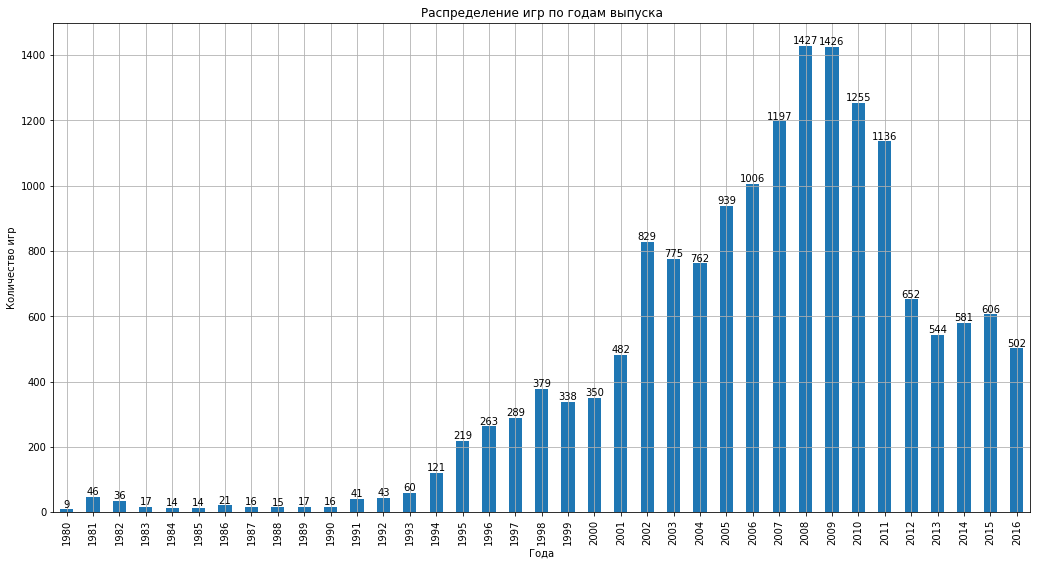

count      37.000000
mean      444.405405
std       451.591535
min         9.000000
25%        36.000000
50%       338.000000
75%       762.000000
max      1427.000000
Name: year_of_release, dtype: float64

In [25]:
ax = data.groupby('year_of_release').size().plot(kind='bar',figsize=(17.5,9)) #Визуализируем распределение игр по годам
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # центр столбца
        bar.get_height(),                   # высота столбца
        int(bar.get_height()),              # текст: высота столбца
        ha='center',                        # горизонтальное выравнивание
        va='bottom',                        # вертикальное выравнивание
        fontsize=10                         # размер текста
)
plt.title('Распределение игр по годам выпуска')
plt.grid()
plt.ylabel('Количество игр')
plt.xlabel('Года')
plt.show()
data['year_of_release'].value_counts().describe()

На графике хорошо видно, что игры до 1995 года выпускались очень редко, эти периоды нам не важны (от 9 до 100 игр в год). С 1995 по 2000 год начинается рост выпуска игр (примерно от 250 до 400 игр в год). Игры стали обретать популярность с 2000 по 2011 год, а основной пик пришёлся на период с 2005 по 2011 год, количество игр в год не понижалось ниже 900. Самое большое количество игр было выпущенно в 2008 и 2009 году (1400+ игр в год).

##### Продажи игр  по платформам

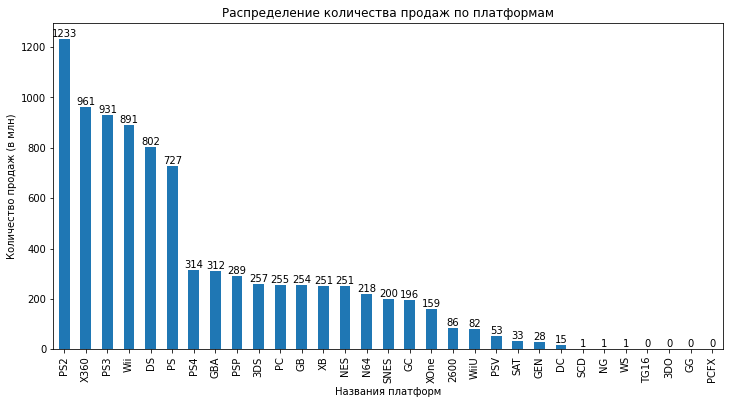

In [26]:
platform_sales = data.groupby('platform')['total_sales'].sum()
plt.figure(figsize=(12,6))
ax = platform_sales.sort_values(ascending=False).plot(kind='bar')
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10)
plt.title('Распределение количества продаж по платформам')
plt.xlabel('Названия платформ')
plt.ylabel('Количество продаж (в млн)')
plt.show()

In [27]:
platform_sales = platform_sales.reset_index()
platform_sales = platform_sales.loc[platform_sales['total_sales'] > 500]
platform_sales.sort_values('total_sales',ascending=False)

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.33
26,Wii,891.18
4,DS,802.78
15,PS,727.58


Были выбраны платформы с наибольшими суммарными продажами : 

* PS2	
* X360	
* PS3
* Wii
* DS
* PS

Эти платформы имеют минимум в два раза больше проданных игр в сравнении с другими платформами.

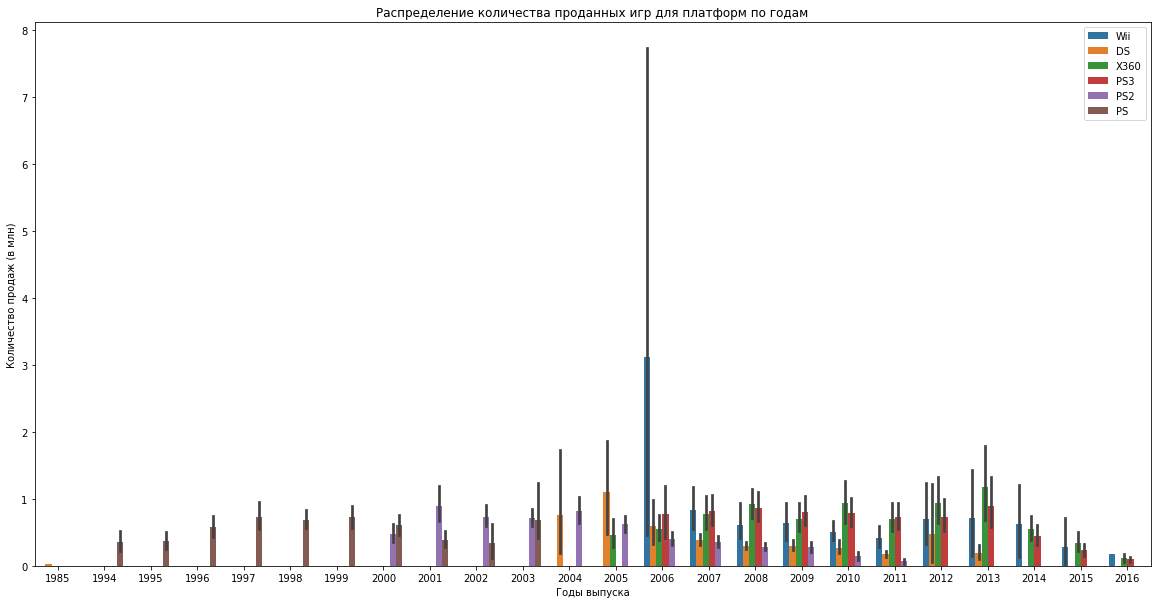

In [28]:
#Гистограмма количества проданных игр для платформ по годам
plt.figure(figsize=(20,10))
sns.barplot(
    data=data.loc[data['platform'].isin(platform_sales['platform'].unique())],
    x='year_of_release',
    y='total_sales',
    hue='platform')
plt.title('Распределение количества проданных игр для платформ по годам')
plt.legend()
plt.ylabel('Количество продаж (в млн)')
plt.xlabel('Годы выпуска')
plt.show()

In [29]:
platform_period = data.loc[data['year_of_release'] != 1985].groupby('platform')['year_of_release'].agg(['min','max']).reset_index()
platform_period = platform_period.loc[platform_period['platform'].isin(platform_sales['platform'])]
platform_period['years_life'] = platform_period['max'] - platform_period['min']
display(platform_period)
print("Среднее значение жизни платформы:", platform_period['years_life'].mean())

,platform,min,max,years_life
4,DS,2004,2013,9
15,PS,1994,2003,9
16,PS2,2000,2011,11
17,PS3,2006,2016,10
26,Wii,2006,2016,10
28,X360,2005,2016,11


Среднее значение жизни платформы: 10.0


# Изменить то что ниже и выше
С момента появления и до исчезновения платформы проходит в среднем 10 лет. Имеется выброс в виде одной игры, выпущенной для платформы Nintendo DS в 1985 году, другие игры с 1985 по 1994 год не продавались. Поэтому это отдельный шум в данных, который я не стал брать в свои расчёты.

Для прогноза на 2017 год нужен актуальный период. Прогноз стоит делать на тех платформах, которые ещё обладают спросом в 2016 году.Исходя из полученной информации я считаю,что актуальным периодом для прогноза будет являться 2014-2016 год.

In [30]:
data = data.loc[(data['year_of_release'] >= 2014)] #Срезаю данные по актуальному периоду

Были выбраны потенциально прибыльные платформы

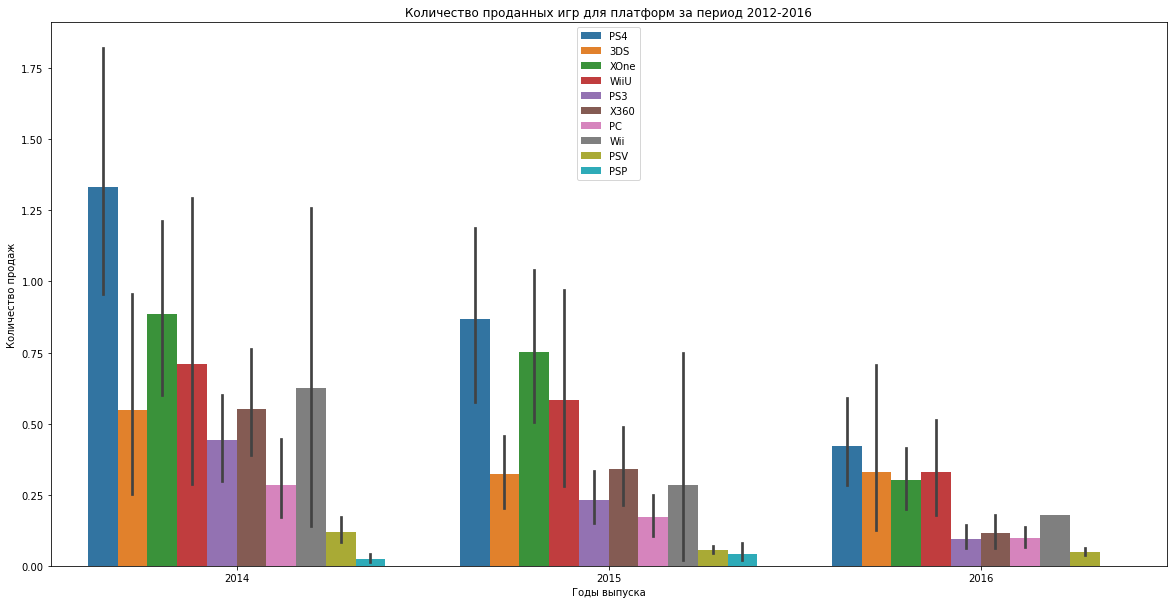

In [31]:
plt.figure(figsize=(20,10))
sns.barplot(
    data=data,
    x='year_of_release',
    y='total_sales',
    hue='platform'
)
plt.title('Количество проданных игр для платформ за период 2012-2016')
plt.legend()
plt.ylabel('Количество продаж')
plt.xlabel('Годы выпуска')
plt.show()

*2014*

Исходя из информации на графике можно сказать, что в 2014 году лидером продаж является платформа PS4. PS4 обходит вторую платформу по продажам XOne в 1.5 раза. Наименьшее количество продаж имеют PSP и PSV, их продажи меньше продаж PS4 примерно в 10 раз. 

*2015*

Стоит отметить, что платформа XOne в 2015 году поднялась по продажам видеоигр и практически сравнялась с продажами PS4. Платформа WiiU хоть и немного уступает по продажам двум лидирующим платформам, но продолжает показывать конкурентоспособные показатели продаж. Продажи видеоигр для Wii, X360 и PS3 сильно упали, а игры для платформ PSV и PSP почти не собирают продаж. 

*2016*

Важно помнить, что данные в 2016 году не полные, поэтому из-за малого объёма информации распределение данных может быть не точным. В 2016 году продажи для PSP полностью прекратились. PS4 продолжает оставаться лидером продаж, а платформы XOne и WiiU остаются сильными конкурентами на рынке. Платформа 3DS показала заметный рост и имеет широкий доверительный интервал, из этого следует, что рост продаж для 3DS может быть искажен неполнотой данных. Wii визуально находится на 5ом месте по продажам, но доверительный интервал отсутствует, что может говорить нам о единственной распроданной игре, такие данные не подойдут для прогноза. Платформа PSV попрежнему собирает наименьшее количество продаж.

Из анализа графика можно сделать вывод, что перспективными платформами являются: PS4,3DS,X0ne,WiiU. 

##### Boxplot распределения продаж для перспективных платформ

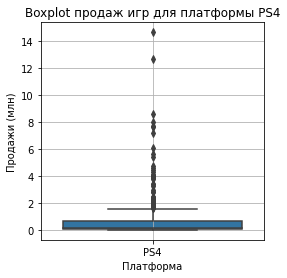

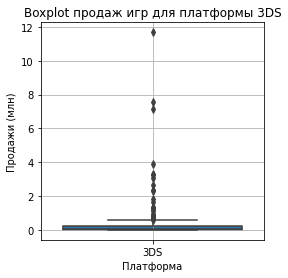

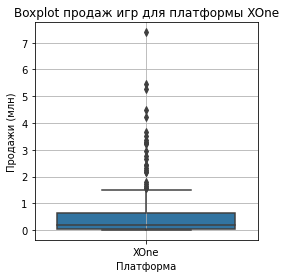

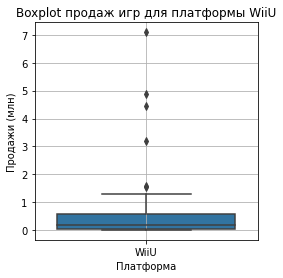

In [32]:
for i in ['PS4','3DS','XOne','WiiU']:
    plt.figure(figsize=(4,4))
    sns.boxplot(data=data.query('platform == @i'), x='platform', y='total_sales')
    plt.xlabel('Платформа')
    plt.ylabel('Продажи (млн)')
    plt.grid()
    plt.title(f'Boxplot продаж игр для платформы {i}')
    plt.show()

На графиках можно наблюдать, что большинство продаж лежит в нижнем диапазоне, но также встречаются и редкие очень большие продажи.

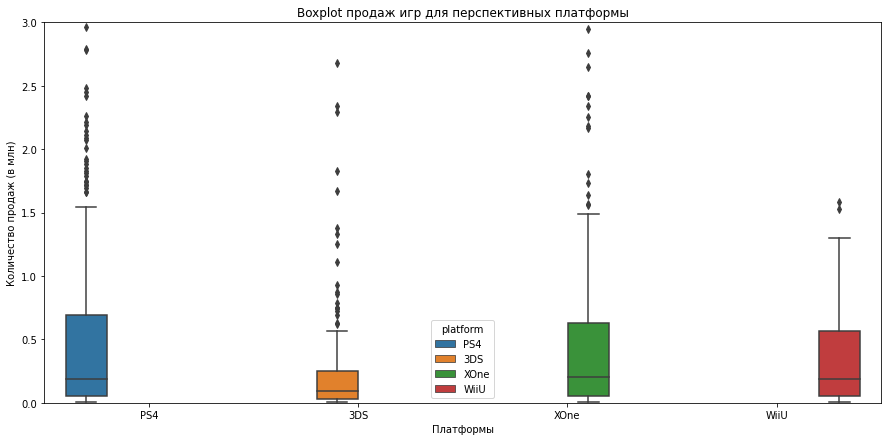

Описание данных о PS4:
 count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: total_sales, dtype: float64 

Описание данных о 3DS:
 count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: total_sales, dtype: float64 

Описание данных о XOne:
 count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: total_sales, dtype: float64 

Описание данных о WiiU:
 count    73.000000
mean      0.588767
std       1.161467
min       0.010000
25%       0.050000
50%       0.190000
75%       0.570000
max       7.090000
Name: total_sales, dtype: float64


In [33]:
plt.figure(figsize=(15,7))
sns.boxplot(
    data=data.loc[data['platform'].isin(['PS4','XOne','3DS','WiiU'])],
    x = 'platform',
    y = 'total_sales',
    hue = 'platform'
)
plt.title('Boxplot продаж игр для перспективных платформы')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж (в млн)')
plt.ylim(0,3)
plt.show()
print("Описание данных о PS4:\n",data.query('platform == "PS4"')['total_sales'].describe(),"\n")
print("Описание данных о 3DS:\n",data.query('platform == "3DS"')['total_sales'].describe(),"\n")
print("Описание данных о XOne:\n",data.query('platform == "XOne"')['total_sales'].describe(),"\n")
print("Описание данных о WiiU:\n",data.query('platform == "WiiU"')['total_sales'].describe())

###### Обобщающий вывод по boxplot
* **PS4**: В межквартильном интервале лежат наибольшие показатели продаж в сравнении с другими платформами. На графике можно видеть, что очень много значений выбросов лежат выше верхней границы.  Длинные границы графика boxplot указывают на то, что данные расположены вокруг медианы неравномерно. 50% продаж лежит в интервале от 0.06 млн и до 0.69 млн. Медианное значение продаж равно 0.185 млн. В данных присутствуют как очень большие продажи (до 14.6 млн), которые сильно превышают 75% всех продаж, так и совсем не успешные продажи (0.01 млн). Это также подверждает стандартное отклонение равное 1.61
* **3DS**: Продажи расположены равномерно воркуг медианы. Выбросов выше верхней границы много. Медианой является 0.09 млн продаж. В межквартильном интервале находятся значения от 0.03 млн и до 0.25млн распроданных копий, но бывают и очень высокие продажи, которые сравнимы с наибольшими продажами PS4. 
* **XOne**: Распределение продаж для платформы XOne очень схоже с распределением PS4. Половина продаж находится в интервале между 0.05 млн и 0.63 млн. Медианное значение равно 0.20 млн продаж. Одна игра была продана тиражом свыше 11 млн копий.
* **WiiU**: Медианное количество продаж равно 0.19 млн. 50% данных лежит в интервале от 0.05 млн и до 0.57 млн продаж. Данные распределены неравномерно, а выбросов очень мало.

##### Влияние отзывов на продажи

In [34]:
data_user_score = data.copy() #Создаём датафрейм для отчистки user_score от NaN
data_critic_score = data.copy() #Создаём датафрейм для отчистки critic_score от NaN
#Проверка
display(data_user_score.head())
data_critic_score.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98


Создал два отчищенных датафрейма

In [35]:
data_user_score = data_user_score.dropna(subset=['user_score']) #Удаление пустых значений в столбце user_score
print("Количество строк в датафрейме",data_user_score.shape[0]) #Колво строк
data_user_score.isna().sum() #Вывод количества пропущенных значений в датафрейме

Количество строк в датафрейме 888


name                 0
platform             0
year_of_release      0
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score       184
user_score           0
rating               0
total_sales          0
dtype: int64

In [36]:
data_critic_score = data_critic_score.dropna(subset=['critic_score']) #Удаление пустых значений в столбце critic_score
print("Количество строк в датафрейме",data_critic_score.shape[0]) #Колво строк
data_critic_score.isna().sum() #Вывод количества пропущенных значений в датафрейме

Количество строк в датафрейме 718


name                0
platform            0
year_of_release     0
genre               0
na_sales            0
eu_sales            0
jp_sales            0
other_sales         0
critic_score        0
user_score         14
rating              0
total_sales         0
dtype: int64

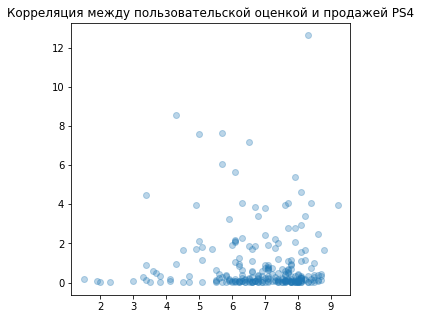

Корреляция между пользовательской оценкой и продажей PS4: -0.04


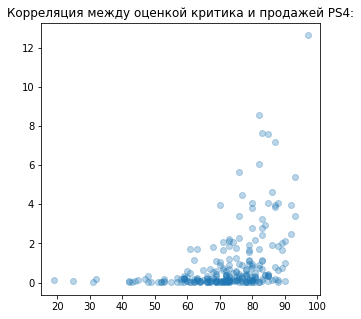

Корреляция между оценкой критика и продажей PS4: 0.4


In [37]:
plt.figure(figsize=(5,5))
plt.scatter(
    data_user_score.query('platform == "PS4"')['user_score'],
    data_user_score.query('platform == "PS4"')['total_sales'],alpha=0.3
)
plt.title('Корреляция между пользовательской оценкой и продажей PS4')
plt.show()
print(
    "Корреляция между пользовательской оценкой и продажей PS4:",
    data_user_score.query('platform == "PS4"')['user_score'].corr(data_user_score.query('platform == "PS4"')['total_sales']).round(2)
)
plt.figure(figsize=(5,5))
plt.scatter(
    data_critic_score.query('platform == "PS4"')['critic_score'],
    data_critic_score.query('platform == "PS4"')['total_sales'],alpha=0.3
)
plt.title('Корреляция между оценкой критика и продажей PS4:')
plt.show()
print(
    "Корреляция между оценкой критика и продажей PS4:",
    data_critic_score.query('platform == "PS4"')['critic_score'].corr(data_critic_score.query('platform == "PS4"')['total_sales']).round(2)
)

Корреляции между пользовательской оценкой и продажей PS4 не наблюдается.Положительная корреляция между оценкой критика и продажей PS4 присутствует, но она очень слабая.

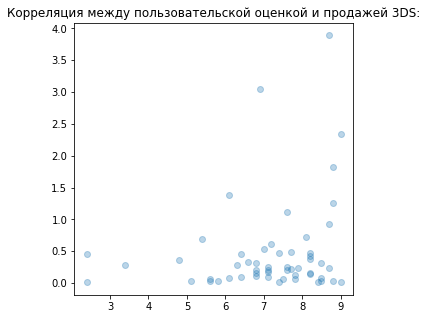

Корреляция между пользовательской оценкой и продажей 3DS: 0.22


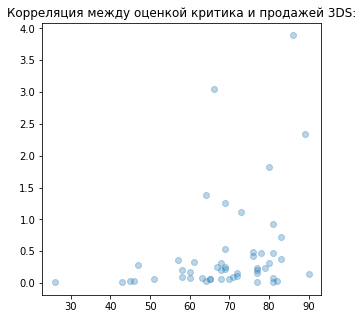

Корреляция между оценкой критика и продажей 3DS: 0.31


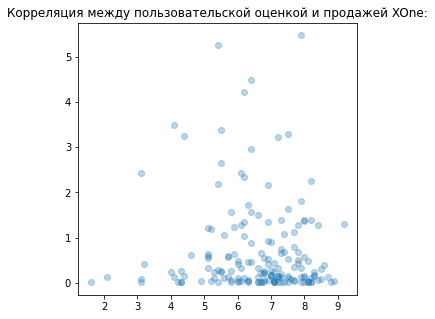

Корреляция между пользовательской оценкой и продажей XOne: -0.07


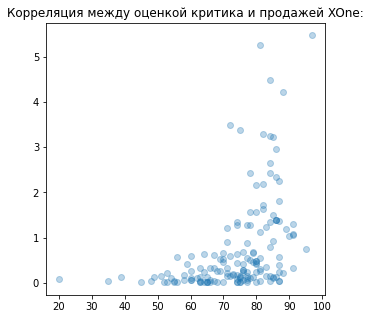

Корреляция между оценкой критика и продажей XOne: 0.43


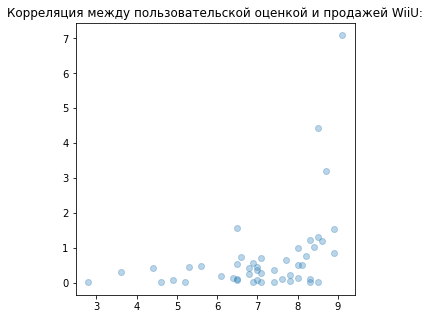

Корреляция между пользовательской оценкой и продажей WiiU: 0.41


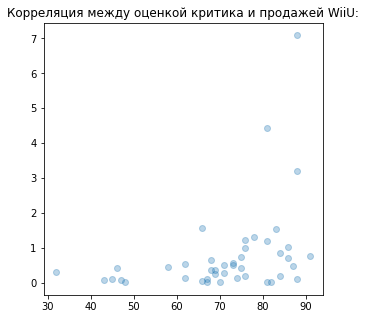

Корреляция между оценкой критика и продажей WiiU: 0.37


In [38]:
for i in ["3DS",'XOne','WiiU']:
    plt.figure(figsize=(5,5))
    plt.scatter(
        data_user_score.query('platform == @i')['user_score'],
        data_user_score.query('platform == @i')['total_sales'],alpha=0.3
    )
    plt.title(f'Корреляция между пользовательской оценкой и продажей {str(i)}:')
    plt.show()
    print(
        f"Корреляция между пользовательской оценкой и продажей {str(i)}:",
        data_user_score.query('platform == @i')['user_score'].corr(data_user_score.query('platform == @i')['total_sales']).round(2)
    )
    plt.figure(figsize=(5,5))
    plt.scatter(
        data_critic_score.query('platform == @i')['critic_score'],
        data_critic_score.query('platform == @i')['total_sales'],alpha=0.3
    )
    plt.title(f'Корреляция между оценкой критика и продажей {str(i)}:')
    plt.show()
    print(
        f"Корреляция между оценкой критика и продажей {str(i)}:",
        data_critic_score.query('platform == @i')['critic_score'].corr(data_critic_score.query('platform == @i')['total_sales']).round(2)
    )

###### Обобщающий вывод влияния отзывов на продажи
Можно заметить, что в среднем оценки пользователей имеют более низкую корреляцию с продажами, чем оценки критиков. В среднем корреляция между оценкой критиков и продажами равна примерно 0.38. Однако уровень корреляции по-прежнему недостаточен, чтобы утверждать о наличии прямой взаимосвязи между оценками и продажами. Мы можем говорить о том, что оценки немного способствуют повышению продаж, но продажи не зависят от оценок напрямую.

##### Распределение продаж игр по жанрам

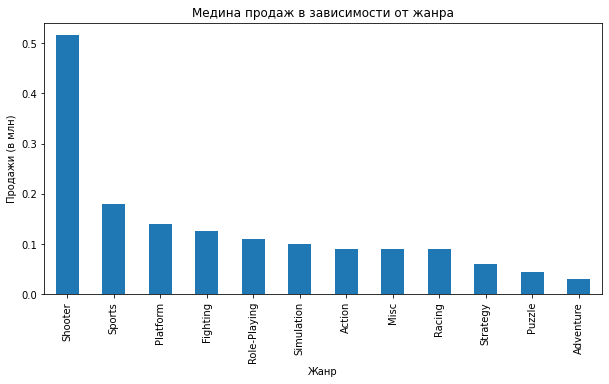

In [39]:
plt.figure(figsize=(10,5))
data.groupby('genre')['total_sales'].median().sort_values(ascending=False).plot(kind='bar')
plt.title('Медина продаж в зависимости от жанра')
plt.xlabel('Жанр')
plt.ylabel('Продажи (в млн)')
plt.show()

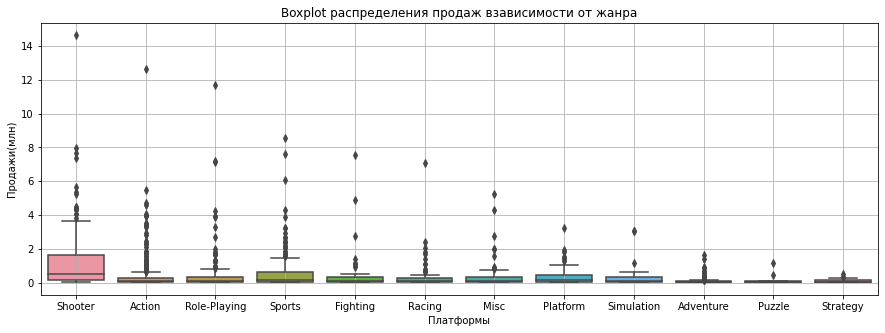

In [40]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x = 'genre', y = 'total_sales')
plt.title('Boxplot распределения продаж взависимости от жанра')
plt.ylabel('Продажи(млн)')
plt.xlabel('Платформы')
plt.grid()
plt.show()


Жанр shooter имеет наибольшее медианное количество продаж среди всех жанров игр и превышает их более чем в два раза, а жанры puzzle,adventure и strategy имеют наименьшее медианное количество продаж.

#### Портрет пользователя каждого региона

##### Самые популярные платформы (топ-5)

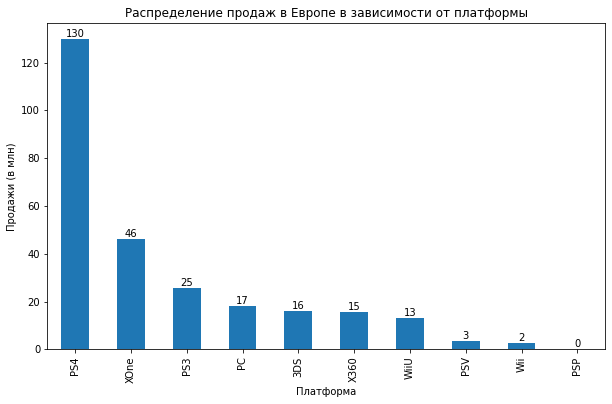

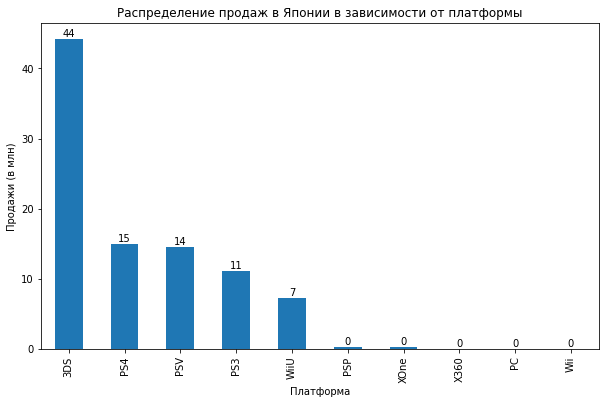

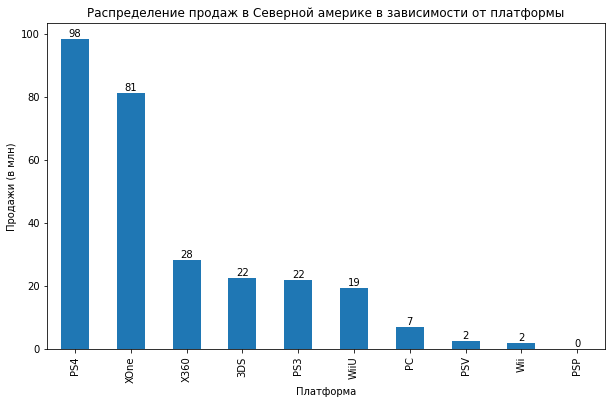

In [41]:
for i in ['eu_sales','jp_sales','na_sales']:
    plt.figure(figsize=(10,6))
    ax = data.groupby('platform')[i].sum().sort_values(ascending=False).plot(kind='bar')
    for bar in ax.patches:
            ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            int(bar.get_height()),
            ha='center',
            va='bottom',
            fontsize=10)
    if i == 'eu_sales':
        plt.title('Распределение продаж в Европе в зависимости от платформы')
    elif i == 'jp_sales':
        plt.title('Распределение продаж в Японии в зависимости от платформы')
    else:
        plt.title('Распределение продаж в Северной америке в зависимости от платформы')
    plt.xlabel('Платформа')
    plt.ylabel('Продажи (в млн)')
    plt.show()

Самые популярные платформы в Европе:   
* Топ 1: PS4
* Топ 2: XOne
* Топ 3: PS3
* Топ 4: PC
* Топ 5: 3DS

Самые популярные платформы в Японии:
* Топ 1: 3DS
* Топ 2: PS4
* Топ 3: PSV
* Топ 4: PS3
* Топ 5: WiiU

Самые популярные платформы в Северной америке:
* Топ 1: PS4
* Топ 2: XOne
* Топ 3: X360
* Топ 4: 3DS
* Топ 5: PS3

##### Самые популярные жанры (топ-5)

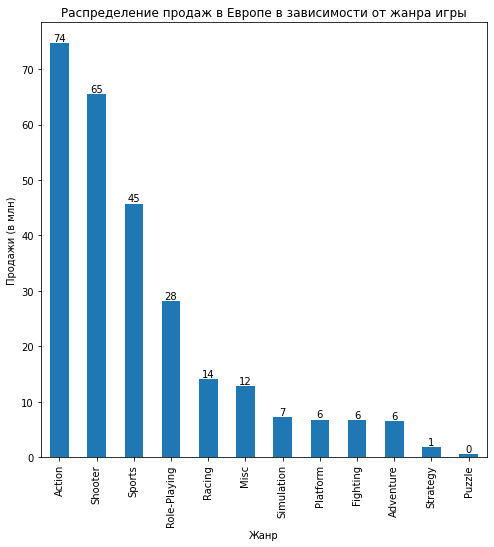

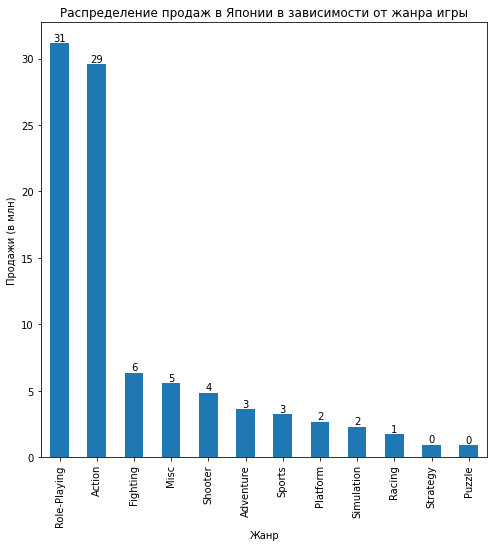

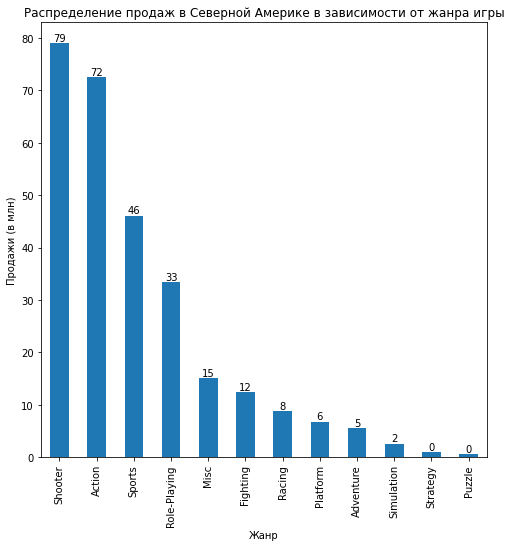

In [42]:
for i in ['eu_sales','jp_sales','na_sales']:
    plt.figure(figsize=(8,8))
    ax = data.groupby('genre')[i].sum().sort_values(ascending=False).plot(kind='bar')
    for bar in ax.patches:
            ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            int(bar.get_height()),
            ha='center',
            va='bottom',
            fontsize=10)
    if i == 'eu_sales':
        plt.title('Распределение продаж в Европе в зависимости от жанра игры')
    elif i == 'jp_sales':
        plt.title('Распределение продаж в Японии в зависимости от жанра игры')
    else:
        plt.title('Распределение продаж в Северной Америке в зависимости от жанра игры')
    plt.xlabel('Жанр')
    plt.ylabel('Продажи (в млн)')
    plt.show()

Самые популярные жанры в Европе:   
* Топ 1: Action
* Топ 2: Shooter
* Топ 3: Sprots
* Топ 4: Role-Playing
* Топ 5: Racing

Самые популярные жанры в Японии:
* Топ 1: Role-Playing
* Топ 2: Action
* Топ 3: Fighting
* Топ 4: Misc
* Топ 5: Shooter

Самые популярные жанры в Северной америке:
* Топ 1: Shooter
* Топ 2: Action
* Топ 3: Sports
* Топ 4: Role-Playing
* Топ 5: Misc

##### Влияет ли возрастной рейтинг на продажи в отдельном регионе

In [43]:
#unknown доминирует на графиках, поэтому решил создать отдельный датафрейм с рейтингом без unknown
rating_corr = data.copy()
rating_corr = rating_corr.query('rating != "unknown"')
print("Количество строк в таблице:",rating_corr.shape[0])
rating_corr['rating'].unique()

Количество строк в таблице: 940


array(['M', 'E', 'T', 'E10+'], dtype=object)

In [44]:
#Добавляем столбец с числовыми категориями для проверки на корреляцию
rating_corr['rating_num'] = rating_corr['rating'].map({'M':1, 'E':2, 'T':3, 'E10+':4})
rating_corr['rating_num'].unique()

array([1, 2, 3, 4])

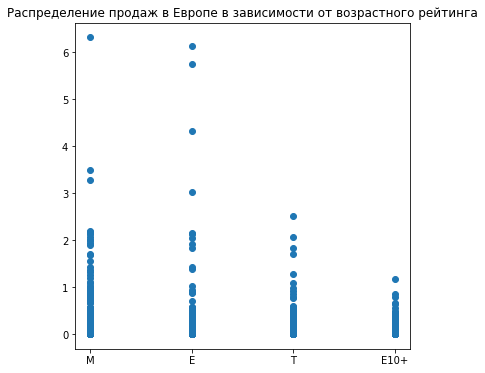

-0.16741785402689466


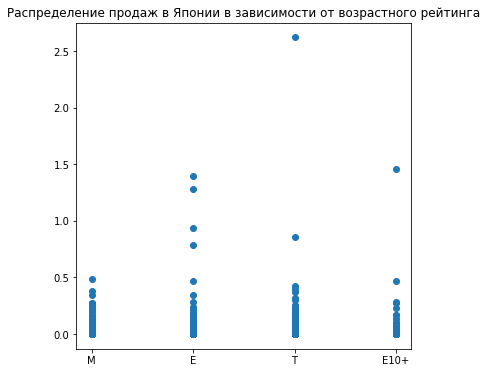

0.008525347748107167


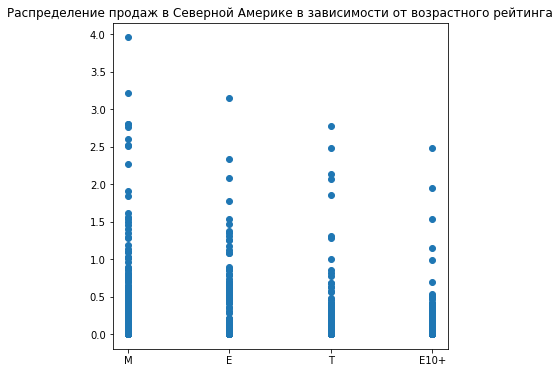

-0.1681498113723833


In [45]:
for i in ['eu_sales','jp_sales','na_sales']:
    plt.figure(figsize=(6,6))
    plt.scatter(rating_corr['rating'],rating_corr[i])
    if i == 'eu_sales':
        plt.title('Распределение продаж в Европе в зависимости от возрастного рейтинга')
    elif i == 'jp_sales':
        plt.title('Распределение продаж в Японии в зависимости от возрастного рейтинга')
    else:
        plt.title('Распределение продаж в Северной Америке в зависимости от возрастного рейтинга')
    plt.show()
    print(rating_corr['rating_num'].corr(rating_corr[i]))

Взаимосвязи между возрастным рейтингом и продажами нет ни в одном регионе

#### Проверка гипотез

##### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза (H0) - Пользовательские рейтинги платформ Xbox One  и PC равны

Альтернативная гипотеза (H1) - Пользовательские рейтинги платформ Xbox One  и PC не равны

In [46]:
pc_user_score = data_user_score.query('platform == "PC"')['user_score']
xone_user_score = data_user_score.query('platform == "XOne"')['user_score']
display(pc_user_score.head())
print("Объём выборки PC:",pc_user_score.shape[0])
print("Среднее значение выборки PC:",pc_user_score.mean())
display(xone_user_score.head())
print("Объём выборки XOne:",xone_user_score.shape[0])
print("Среднее значение выборки XOne:",xone_user_score.mean())

455     3.9
1515    5.4
1710    7.9
2273    5.7
2746    5.9
Name: user_score, dtype: float64

Объём выборки PC: 122
Среднее значение выборки PC: 6.298360655737705


165    7.9
179    5.4
241    6.4
269    6.2
372    4.1
Name: user_score, dtype: float64

Объём выборки XOne: 165
Среднее значение выборки XOne: 6.594545454545456


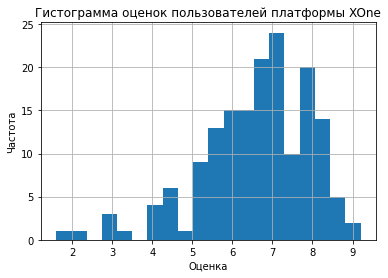

Распределение ненормальное. Shapiro: 2.564911119407043e-05


In [47]:
alpha = 0.05
plt.figure()
xone_user_score.hist(bins=20)
plt.title('Гистограмма оценок пользователей платформы XOne')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()
stat,p = st.shapiro(xone_user_score)
if p < alpha:
    print("Распределение ненормальное. Shapiro:",p)
else:
    print('Распределение нормальное. Shapiro:',p)

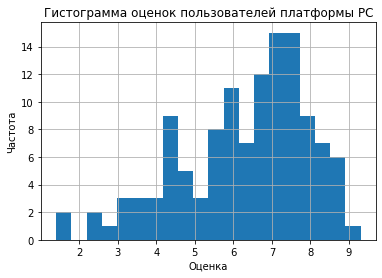

Распределение ненормальное. Shapiro: 0.00017992201901506633


In [48]:
plt.figure()
pc_user_score.hist(bins=20)
plt.title('Гистограмма оценок пользователей платформы PC')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()
stat,p = st.shapiro(pc_user_score)
if p < alpha:
    print("Распределение ненормальное. Shapiro:",p)
else:
    print('Распределение нормальное. Shapiro:',p)

Исходя из полученной информации о распределении я принял решение использовать U-тест Манна-Уитни

In [49]:
utest_platform = st.mannwhitneyu(xone_user_score,pc_user_score,alternative='two-sided')
if utest_platform.pvalue < alpha:
    print('Отклоняем нулевую гипотезу. Pvalue:',utest_platform.pvalue)
else:
    print('Мы не можем отклонить нулевую гипотезу. Pvalue:',utest_platform.pvalue)

Мы не можем отклонить нулевую гипотезу. Pvalue: 0.27752869727762175


Вывод:У нас недостаточно оснований полагать, что средние пользовательские рейтинги платформ Xbox One и PC не равны

##### Средние пользовательские рейтинги игр жанра Action и Sports разные

Нулевая гипотеза (H0) - Пользовательские рейтинги жанров Action и Sports равны

Альтернативная гипотеза (H1) - Пользовательские рейтинги жанров Action и Sports не равны

In [50]:
genre_action = data_user_score.query('genre == "Action"')['user_score']
genre_sports = data_user_score.query('genre == "Sports"')['user_score']
display(genre_action.head())
print("Объём выборки:",genre_action.shape[0])
print("Среднее значение выборки:",genre_action.mean())
display(genre_sports.head())
print("Объём выборки:",genre_sports.shape[0])
print("Среднее значение выборки:",genre_sports.mean())

42     8.3
165    7.9
230    8.1
294    6.3
303    4.9
Name: user_score, dtype: float64

Объём выборки: 297
Среднее значение выборки: 6.760606060606061


77     4.3
94     5.0
143    5.7
263    4.5
313    6.7
Name: user_score, dtype: float64

Объём выборки: 127
Среднее значение выборки: 5.2251968503937


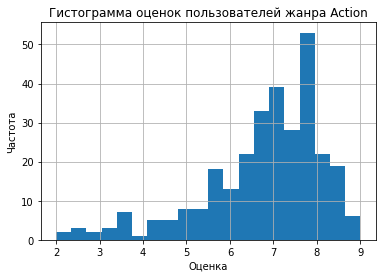

Распределение ненормальное. Shapiro: 1.3702634946849424e-12


In [51]:
plt.figure()
genre_action.hist(bins=20)
plt.title('Гистограмма оценок пользователей жанра Action')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()
stat,p = st.shapiro(genre_action)
if p < alpha:
    print("Распределение ненормальное. Shapiro:",p)
else:
    print('Распределение нормальное. Shapiro:',p)

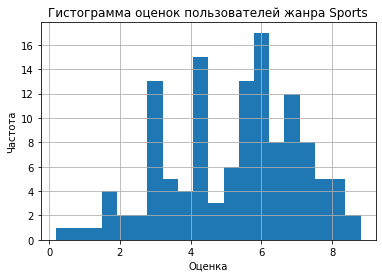

Распределение ненормальное. Shapiro: 0.034661613404750824


In [52]:
plt.figure()
genre_sports.hist(bins=20)
plt.title('Гистограмма оценок пользователей жанра Sports')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()
stat,p = st.shapiro(genre_sports)
if p < alpha:
    print("Распределение ненормальное. Shapiro:",p)
else:
    print('Распределение нормальное. Shapiro:',p)

Распределения выборок оказались ненормальными, было принято решение использовать u-test Манна Уитни

In [53]:
utest_genre = st.mannwhitneyu(genre_action,genre_sports,alternative = 'two-sided')
if utest_genre.pvalue < alpha:
    print('Отклоняем нулевую гипотезу. Pvalue:',utest_genre.pvalue)
else:
    print('Мы не можем отклонить нулевую гипотезу. Pvalue:',utest_genre.pvalue)

Отклоняем нулевую гипотезу. Pvalue: 1.2166879280294303e-16


Вывод:Мы можем утверждать, что пользовательские рейтинги жанров Action и Sports не равны

#### Вывод:
Я провел исследовательский и статистический анализ архива данных интернет-магазина "Стримчик". Перед любым анализом необходимо обработать сырые данные. В выгруженном архиве были найдены пропущенные значения, неверно определённые типы данных и дубликаты. Я создал отдельный датафрейм для отчистки и дальнейшей работы с данными. Пропуски в столбцах name, year_of_release и genre были удалены, так как пропущенных значений было очень мало, а логической замене они не подлежали. User_score и critic_score имели большую часть пропущенных данных, поэтому при замене пустых значений медианой или средним мы могли сильно повлиять на статистические выводы. Было принято решение удалить все пропуски в этих столбцах. Чтобы не терять объём информации я создал две отдельние отчищенные таблицы для user_score и critic_score. Пропуски в столбце с возрастным рейтингом заполнялись константным значением.

В данных были обнаруженны неправильно определённые типы данных столбца user_score и year_of_release. Данные были преобразованы в нужный тип, а также были преобразованы названия столбцов в нижний регистр для большего удобства.

Найденные дубликаты были удалены, а их оригинальные значения остались в датафрейме.

После того, как все данные были обработаны я приступил к исследовательскому анализу данных, направленному на выявление закономерностей и факторов влияющих на продажу игр.Наибольшее количество новых игр было выпущенно в 2008 и 2009 году, а основная тенденция популярности началась с 2000 по 2012 год.

Исходя из полученной выше информации я выбрал актуальный период для прогноза продаж на 2017 год. За актуальный период был взят 2014-2016 год. Я провел анализ продаж по платформам за актуальный период и выяснил, что самыми перспективными платформами являются PS4, 3DS, XOne и WiiU. Также я выяснил, что продажи видеоигр для Wii, X360 и PS3 сильно упали, а игры для платформ PSV и PSP почти не собирают продаж.

Также была проведена проверка зависимости продаж от оценок критиков и пользователей. Корреляционный анализ показал, что оценки критиков имеют более сильную связь с продажами, чем пользовательские оценки. Корреляция показывает слабое влияние на продажи, потому что уровень корреляции остаётся умеренным, что указывает на наличие дополнительных факторов, влияющих на продажи.
Были выявленные самые популярные платформы и жанры игр для каждого региона:

**ТОП 5 ПЛАТФОРМ:**

*Самые популярные платформы в Европе:*
**Топ 1:** PS4, **Топ 2:** XOne, **Топ 3:** PS3, **Топ 4:** PC, **Топ 5:** 3DS

*Самые популярные платформы в Японии:*
**Топ 1:** 3DS, **Топ 2:** PS4, **Топ 3:** PSV, **Топ 4:** PS3, **Топ 5:** WiiU

*Самые популярные платформы в Северной америке:*
**Топ 1:** PS4, **Топ 2:** XOne, **Топ 3:** X360, **Топ 4:** 3DS, **Топ 5:** PS3

**ТОП 5 ЖАНРОВ:**

*Самые популярные жанры в Европе:*
**Топ 1:** Action, **Топ 2:** Shooter, **Топ 3:** Sports, **Топ 4:**: Role-Playing, **Топ 5:** Racing

*Самые популярные жанры в Японии:*
**Топ 1:** Role-Playing, **Топ 2:** Action, **Топ 3:** Fighting, **Топ 4:** Misc, **Топ 5:** Shooter

*Самые популярные жанры в Северной америке:*
**Топ 1:** Shooter, **Топ 2:** Action, **Топ 3:** Sports, **Топ 4:** Role-Playing, **Топ 5:** Misc


**Проверка гипотез:**
* **Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:**

*Нулевая гипотеза (H0) - Пользовательские рейтинги платформ Xbox One и PC равны*

*Альтернативная гипотеза (H1) - Пользовательские рейтинги платформ Xbox One и PC не равны*

**Вывод:** Данных не достаточно, чтобы предполагать, что средние пользовательские оценки платформ Xbox One и PC не равны

* **Средние пользовательские рейтинги игр жанра Action и Sports разные:**

*Нулевая гипотеза (H0) - Пользовательские рейтинги жанров Action и Sports равны*

*Альтернативная гипотеза (H1) - Пользовательские рейтинги жанров Action и Sports не равны*

**Вывод:** Было доказано, что средние пользовательские оценки жанров Action и Sports разные.

**Рекомендации:**

* Стоит сделать упор на платформах PS4, 3DS, XOne и WiiU. Эти платформы показали лучшие результаты продаж с 2014 по 2016 год. Особенно PS4 - она уверенно держала лидурующие позиции все эти годы.
* Стоит подбирать жанры с упором на каждый регион отдельно. Role-playing занимает лидирующее первое место среди самых продаваемых жанров видеоигр в Японии, что достаточно необычно. 
* Стоит делать упор на самых устойчивых и популярных жанрах. Жанр action стабильно входит в топ 2 самых продаваемых жанров, а жанр shooter самый стабильный.
* Отказаться от работы с умирающими* платформами: Wii,PSV,PSP,PS3 и X360